In [1]:
%matplotlib inline

## Advanced example

This is an advanced example of UXsim with automated network generation and traffic management. First, import and setup the simulation world.

In [2]:
from uxsim import *
import pandas as pd

In [3]:
# Simulation definition
W = World(
    name="",
    deltan=5,
    tmax=6000,
    print_mode=1, save_mode=1, show_mode=1,
    random_seed=0,
)

Now we are going to define fairly large-scale simulation scenario by code. This is a grid-shaped arterial road network with diagonal highway. The traffic demand is set to travel from one end of the network to the other. We are going to test how highway toll can improve the traffic situation. Note that we specified user-defined `attribute` of Link to distinguish arterial and highway links.

In [4]:
# Scenario definition
#automated network generation
#generate nodes to create (imax, imax) grid network
imax = 11
jmax = imax
nodes = {}
for i in range(imax):
    for j in range(jmax):
        nodes[i,j] = W.addNode(f"n{(i,j)}", i, j)

#grid-shaped arterial roads
links = {}
for i in range(imax):
    for j in range(jmax):
        if i != imax-1:
            ii = i+1
            jj = j
            links[i,j,ii,jj] = W.addLink(f"l{(i,j,ii,jj)}", nodes[i,j], nodes[ii,jj], length=1000, 
                                         free_flow_speed=15, jam_density=0.2, attribute="arterial")
        if i != 0:
            ii = i-1
            jj = j
            links[i,j,ii,jj] = W.addLink(f"l{(i,j,ii,jj)}", nodes[i,j], nodes[ii,jj], length=1000, 
                                         free_flow_speed=15, jam_density=0.2, attribute="arterial")
        if j != jmax-1:
            ii = i
            jj = j+1
            links[i,j,ii,jj] = W.addLink(f"l{(i,j,ii,jj)}", nodes[i,j], nodes[ii,jj], length=1000, 
                                         free_flow_speed=15, jam_density=0.2, attribute="arterial")
        if j != 0:
            ii = i
            jj = j-1
            links[i,j,ii,jj] = W.addLink(f"l{(i,j,ii,jj)}", nodes[i,j], nodes[ii,jj], length=1000, 
                                         free_flow_speed=15, jam_density=0.2, attribute="arterial")
#diagonal highway
for i in range(imax):
    j = i
    if i != imax-1:
        ii = i+1
        jj = j+1
        links[i,j,ii,jj] = W.addLink(f"l{(i,j,ii,jj)}", nodes[i,j], nodes[ii,jj], length=1000*np.sqrt(2), 
                                     free_flow_speed=30, jam_density=0.2, attribute="highway")
    if i != 0:
        ii = i-1
        jj = j-1
        links[i,j,ii,jj] = W.addLink(f"l{(i,j,ii,jj)}", nodes[i,j], nodes[ii,jj], length=1000*np.sqrt(2), 
                                     free_flow_speed=30, jam_density=0.2, attribute="highway")
        
#traffic demand from edge to edge in grid network
demand_flow = 0.03
demand_duration = 3600
for n1 in [(0,j) for j in range(jmax)]:
    for n2 in [(imax-1,j) for j in range(jmax)]:
        W.adddemand(nodes[n2], nodes[n1], 0, demand_duration, demand_flow)
        W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
for n1 in [(i,0) for i in range(imax)]:
    for n2 in [(i,jmax-1) for i in range(imax)]:
        W.adddemand(nodes[n2], nodes[n1], 0, demand_duration, demand_flow)
        W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)

In order to compare no-toll and with-toll scenarios, we copy the scenario for later re-use.

In [5]:
#copy scenario for re-use (copy.deepcopy does not work for some reason)
import pickle
W_orig = pickle.loads(pickle.dumps(W))


### No-toll scenario

Execute the no-toll scenario and show the results.

simulation setting:
 scenario name: _notoll
 simulation duration:	 6000 s
 number of vehicles:	 50820 veh
 total road length:	 468284.27124746144 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 1200
 number of platoons:	 10164
 number of links:	 460
 number of nodes:	 121
 setup time:		 11.29 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     7175 vehs|  11.7 m/s|     3.63 s
    1200 s|    13290 vehs|  10.6 m/s|     9.32 s
    1800 s|    15685 vehs|   9.6 m/s|    15.46 s
    2400 s|    19230 vehs|   9.1 m/s|    22.05 s
    3000 s|    20325 vehs|   8.8 m/s|    28.21 s
    3600 s|    22925 vehs|   7.6 m/s|    34.75 s
    4200 s|    14525 vehs|  10.0 m/s|    39.50 s
    4800 s|     4440 vehs|  13.9 m/s|    42.22 s
    5400 s|       70 vehs|  15.0 m/s|    42.81 s
    5995 s|        0 vehs|   0.0 m/s|    42.98 s
 simulation finished
results:
 average speed:	 10.3 m/s
 number of co

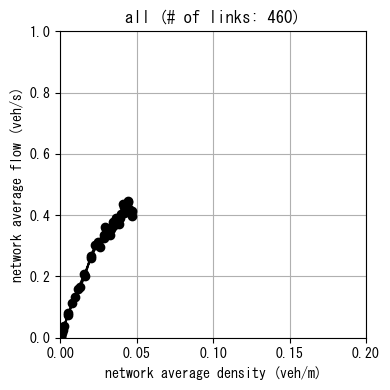

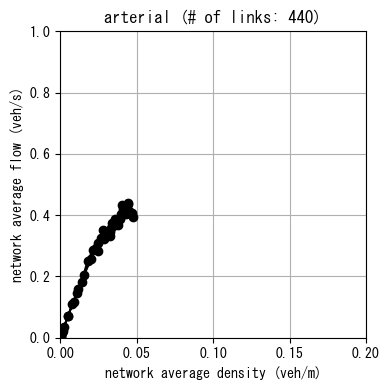

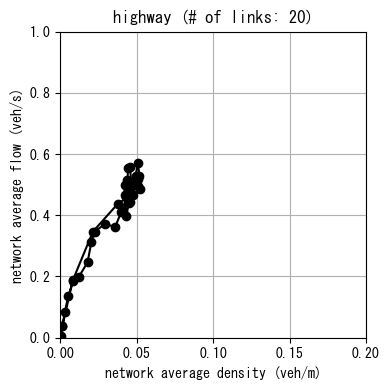

 drawing trajectories...


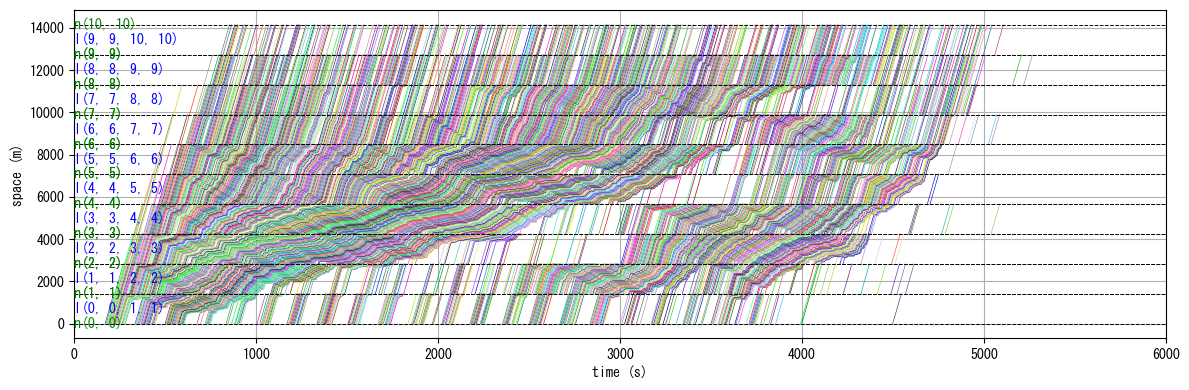

 drawing trajectories...


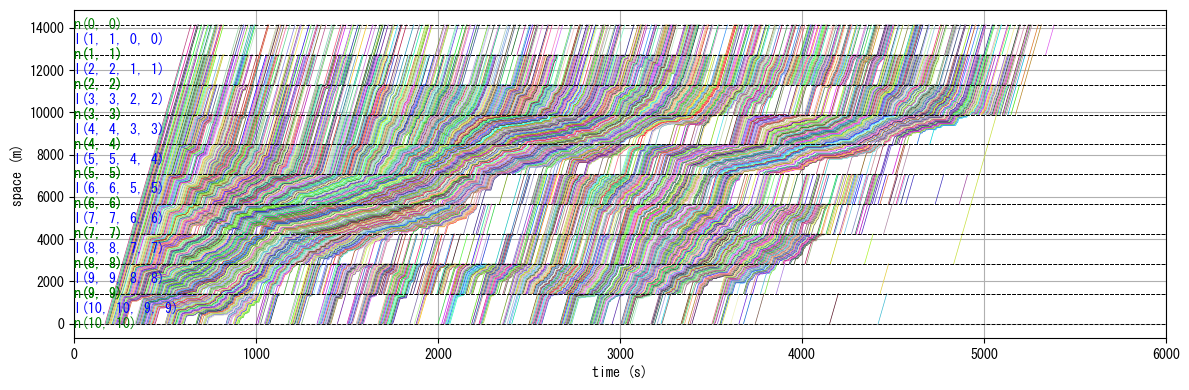

 generating animation...


  0%|          | 0/6 [00:00<?, ?it/s]

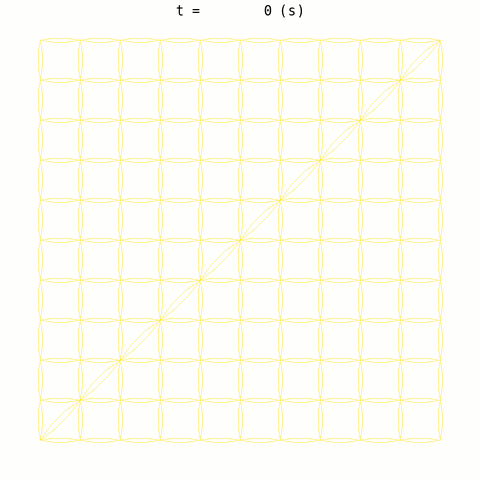

In [6]:
W.name = "_notoll"

# Simulation execution
W.exec_simulation()

# Result visualization
W.analyzer.print_simple_stats()
W.analyzer.macroscopic_fundamental_diagram(figtitle="all")
W.analyzer.macroscopic_fundamental_diagram(figtitle="arterial", links=[link for link in W.LINKS if link.attribute == "arterial"])
W.analyzer.macroscopic_fundamental_diagram(figtitle="highway", links=[link for link in W.LINKS if link.attribute == "highway"])
#trajectories on highway
W.analyzer.time_space_diagram_traj_links([links[i,i,i+1,i+1] for i in range(0,imax-1)])
W.analyzer.time_space_diagram_traj_links([links[i,i,i-1,i-1] for i in range(imax-1,0,-1)])

W.analyzer.network_anim(animation_speed_inverse=5, timestep_skip=200, detailed=0, network_font_size=0, figsize=(4,4))

from IPython.display import display, Image
with open("out_notoll/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

According to "delay ratio" value, this is a quite congested state in overall. We can also confirm that highway links are significantly congested according to time-space diagrams and network animation. This was due to the fact that many travelers were concentrated on the highways, causing huge traffic jams.

### With-toll scenario

Now let's see how highway toll can resolve this issue. We load the defined scenario to new World `W2`. Highway toll can be implemented by setting `route_choice_penalty` parameter of `Link` object. The value of it works as penalty for traveler's route choice as virtually additional travel time (in second). 70 seconds of `route_choice_penalty` roughtly corresponds to 0.5 USD assuming the standard value of time; for example, a traveler who uses 4 highway links (or 5.7km highway road) needs to pay 2 USD.

In [7]:
W2 = pickle.loads(pickle.dumps(W_orig))
W2.name = "_withtoll"

#fixed toll for highway (toll corresponds to route_choice_penalty seconds of travel time per link)
for link in W2.LINKS:
    if link.attribute == "highway":
        link.route_choice_penalty = 70

simulation setting:
 scenario name: _withtoll
 simulation duration:	 6000 s
 number of vehicles:	 50820 veh
 total road length:	 468284.27124746144 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 1200
 number of platoons:	 10164
 number of links:	 460
 number of nodes:	 121
 setup time:		 94.95 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     7175 vehs|  11.7 m/s|     4.14 s
    1200 s|    13260 vehs|  11.0 m/s|    10.09 s
    1800 s|    15255 vehs|  10.5 m/s|    16.70 s
    2400 s|    17760 vehs|  11.3 m/s|    23.60 s
    3000 s|    16695 vehs|  11.2 m/s|    29.99 s
    3600 s|    16970 vehs|  11.5 m/s|    35.63 s
    4200 s|     7560 vehs|  13.9 m/s|    39.36 s
    4800 s|      315 vehs|  15.2 m/s|    40.48 s
    5400 s|        0 vehs|   0.0 m/s|    40.69 s
    5995 s|        0 vehs|   0.0 m/s|    40.87 s
 simulation finished
results:
 average speed:	 12.1 m/s
 number of 

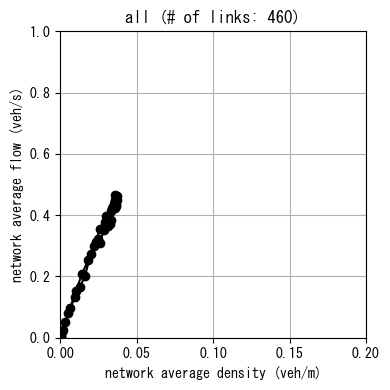

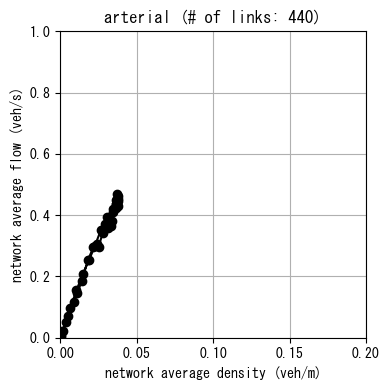

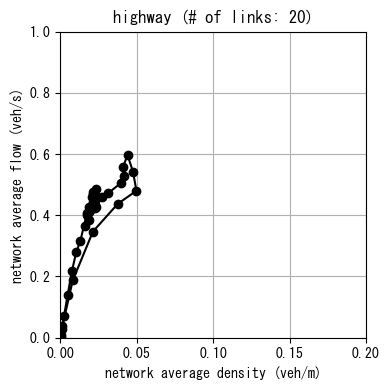

 drawing trajectories...


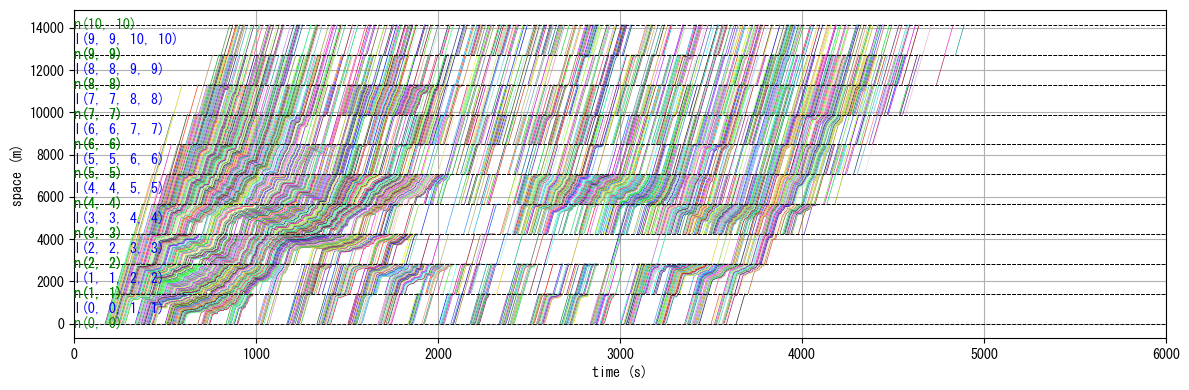

 drawing trajectories...


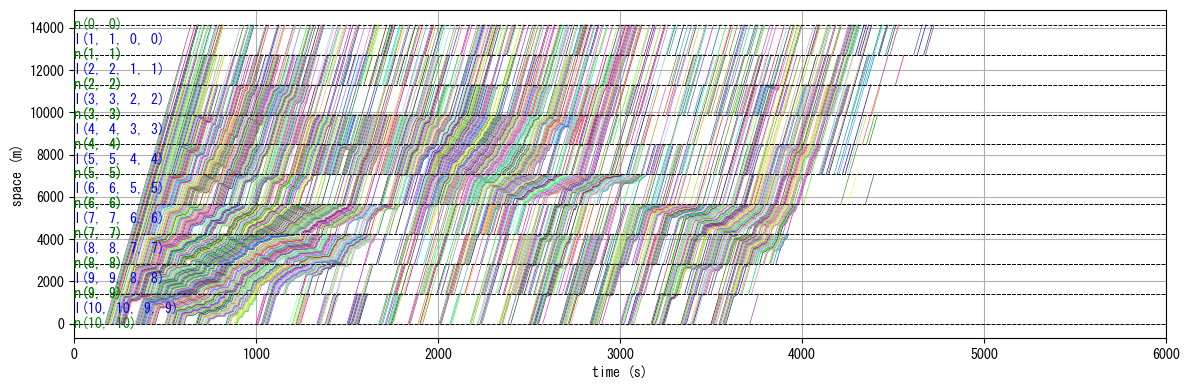

 generating animation...


  0%|          | 0/6 [00:00<?, ?it/s]

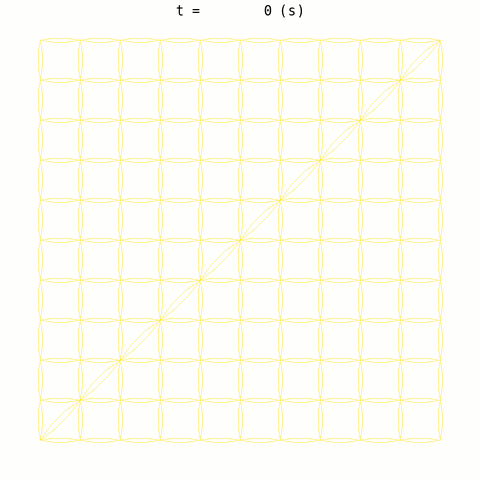

In [8]:
# Simulation execution
W2.exec_simulation()

# Result visualization
W2.analyzer.print_simple_stats()
W2.analyzer.macroscopic_fundamental_diagram(figtitle="all")
W2.analyzer.macroscopic_fundamental_diagram(figtitle="arterial", links=[link for link in W2.LINKS if link.attribute == "arterial"])
W2.analyzer.macroscopic_fundamental_diagram(figtitle="highway", links=[link for link in W2.LINKS if link.attribute == "highway"])
#trajectories on highway
W2.analyzer.time_space_diagram_traj_links([links[i,i,i+1,i+1] for i in range(0,imax-1)])
W2.analyzer.time_space_diagram_traj_links([links[i,i,i-1,i-1] for i in range(imax-1,0,-1)])

W2.analyzer.network_anim(animation_speed_inverse=5, timestep_skip=200, detailed=0, network_font_size=0, figsize=(4,4))
from IPython.display import display, Image
with open("out_withtoll/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

You can see that the "delay ratio" is significantly reduced. Other visualization results also indicated that traffic situations were improved. This was due to the fact that inefficient usage of highway was reduced by toll.

### Dataframe analysis

More quantitative analysis can be easily done by using pandas.Dataframe output. Here we compare some statistics between no-toll and with-toll scenarios.

In [9]:
# Results comparison 

df = W.analyzer.basic_to_pandas()
all_ave_tt = df["average_travel_time"][0]
all_ave_delay = df["average_delay"][0]

df = W.analyzer.link_to_pandas()
highway_user = (df
                [df["link"].isin([l.name for l in W.LINKS if l.attribute=="highway"])]
                ["traffic_volume"]
                .sum())
highway_ave_tt = (df
                  [df["link"].isin([l.name for l in W.LINKS if l.attribute=="highway"])]
                  ["average_travel_time"]
                  .mean())

df = W2.analyzer.basic_to_pandas()
all_ave_tt2 = df["average_travel_time"][0]
all_ave_delay2 = df["average_delay"][0]

df = W2.analyzer.link_to_pandas()
highway_user2 = (df
                 [df["link"].isin([l.name for l in W.LINKS if l.attribute=="highway"])]
                 ["traffic_volume"]
                 .sum())
highway_ave_tt2 = (df
                   [df["link"].isin([l.name for l in W.LINKS if l.attribute=="highway"])]
                   ["average_travel_time"]
                   .mean())

print(f"""no toll case
- average travel time: {all_ave_tt}
- average delay: {all_ave_delay}
- # of highway link users: {highway_user}
- average highway link travel time: {highway_ave_tt}
toll case
- average travel time: {all_ave_tt2}
- average delay: {all_ave_delay2}
- # of highway link users: {highway_user2}
- average highway link travel time: {highway_ave_tt2}
""")

no toll case
- average travel time: 1386.4536599763871
- average delay: 634.0770804386239
- # of highway link users: 44930
- average highway link travel time: 116.6421949249966
toll case
- average travel time: 1114.715171192444
- average delay: 362.33859165468067
- # of highway link users: 38495
- average highway link travel time: 80.60047029513257



You can see that the number of highway users were decreased, and the overall traffic efficiency was improved.